# [Example 1: Symbolic Regressor](https://gplearn.readthedocs.io/en/stable/examples.html#symbolic-regressor)

This example demonstrates using the `SymbolicRegressor` to fit a symbolic relationship.

Let’s create some synthetic data based on the relationship $y = X_0^{2} - X_1^{2} + X_1 - 1$:

In [1]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

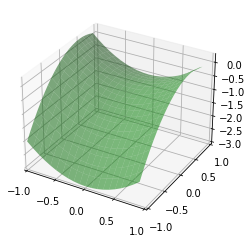

In [2]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

We can create some random training and test data that lies on this surface too:

In [4]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

Now let’s consider how to fit our `SymbolicRegressor` to this data. Since it’s a fairly small dataset, we can probably use a large population since training time will still be pretty fast. We’ll evolve 20 generations unless the error falls below 0.01. Examining the equation, it looks like the default function set of addition, subtraction, multiplication and division will cover us. Let’s bump up the amount of mutation and subsample so that we can watch the [OOB error](https://qiita.com/kenmatsu4/items/1152d6e5634921d9246e) evolve. We’ll also increase the parsimony coefficient to keep our solutions small, since we know the truth is a pretty simple equation:

In [7]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.37m
   1     9.97          1.70233        5         0.320202         0.624787     50.54s
   2     7.72          1.94456       11         0.239537         0.533148     44.61s
   3     5.41         0.990157        7         0.235676         0.719906     39.61s
   4     4.66         0.894443       11         0.103946         0.103946     38.95s
   5     5.41         0.940242       11         0.060802         0.060802     34.61s
   6     6.78          1.09536       11      0.000781474      0.000781474     33.34s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

The evolution process stopped early as the error of the best program in the 9th generation was better than 0.01. It also appears that the parsimony coefficient was just about right as the average length of the programs fluctuated around a bit before settling on a pretty reasonable size. Let’s look at what our solution was:

In [8]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


Interestingly, this does not have the same structure as our target function. But let’s expand the mathematics out:

$$y = (-0.999 + X_1) - ((X_1 - X_0) \times (X_0 + X_1))$$

$$y = X_1 - 0.999 - (X_1 X_0 + X_1^{2} - X_0^{2} - X_0 X_1)$$

$$y = X_0^{2} - X_1^{2} + X_1 - 0.999$$

Great, but let’s compare with some other non-linear models to see how they do:

In [11]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [10]:
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor()

We can plot the decision surfaces of all three to visualize each one:

In [15]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)

y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)

y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

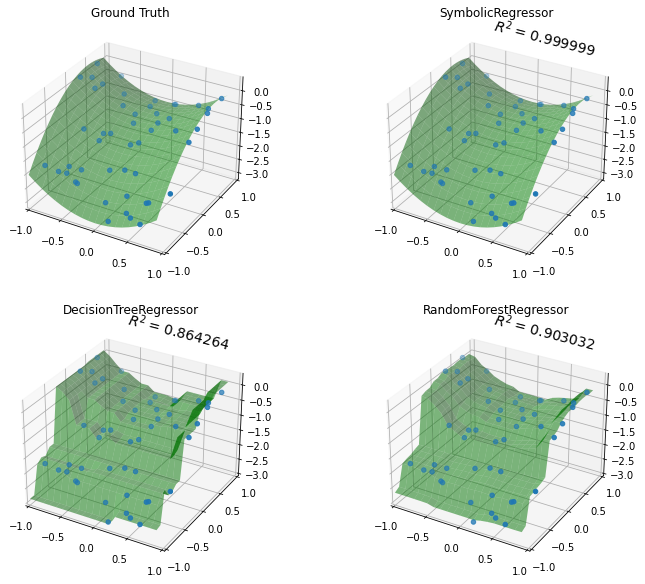

In [16]:
fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()